In [1]:
import os
import tweepy as tw
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ast
import re
import random
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

In [2]:
bearer_token= 'secret-token'

### Retrieving Tweets

In [3]:
api = tw.Client(bearer_token, wait_on_rate_limit=True)

In [4]:
search = "(cristiano OR ronaldo)" + ' -is:retweet'
data = ['id','created_at','author_id','text','public_metrics','lang']
includes = ['username', 'public_metrics', 'verified']
start = '2021-09-11T00:00:00Z'
end = '2021-09-12T00:00:00Z'

tweets = tw.Paginator(api.search_recent_tweets, query=search, max_results=100, tweet_fields=data,
                      expansions=["author_id"], user_fields=includes, start_time=start, end_time=end).flatten(limit=500000)

In [5]:
getTweets = [[x[0].id, x[0].created_at, x[0].text, x[0].lang, x[0].public_metrics, x[1].username, x[1].public_metrics, x[1].verified] for x in tweets]

### Initialization

In [6]:
df = pd.DataFrame(data=getTweets, columns=["tweet_id", "time", "text", "lang", "tweet_metrics", "username", "user_metrics", "verified"])

In [7]:
df.to_csv('extracted_data.csv', index = False, header=True)

In [8]:
df = pd.read_csv('extracted_data.csv', parse_dates=['time']) #I start here if the kernel restarted

In [9]:
df.head()

,tweet_id,time,text,lang,tweet_metrics,username,user_metrics,verified
0,1436841988150726657,2021-09-11 23:59:59+00:00,prêmio veneza arroz TV GLOBINHO #GOLOUD #LBFF ...,pt,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",CARLSGIF,"{'followers_count': 1201, 'following_count': 1...",False
1,1436841986879750148,2021-09-11 23:59:59+00:00,@ManUtd @Cristiano Wonderful,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NguynTu33511542,"{'followers_count': 1, 'following_count': 25, ...",False
2,1436841981922136065,2021-09-11 23:59:58+00:00,“Who needs Ronaldo?” https://t.co/A1J5dzWOPZ,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",afonso_santos08,"{'followers_count': 147, 'following_count': 69...",False
3,1436841981792210947,2021-09-11 23:59:58+00:00,@HowardDonald @ManUtd @Cristiano Wohoo He's ba...,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",yasmin_ali10,"{'followers_count': 3204, 'following_count': 3...",False
4,1436841979602608130,2021-09-11 23:59:57+00:00,"still rewatching manutd vs newcastle goals, st...",en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",AmirulParker,"{'followers_count': 252, 'following_count': 21...",False


In [10]:
len(df)

389471

### Splitting

In [11]:
tweet_metrics = pd.DataFrame(df['tweet_metrics'].apply(lambda x: ast.literal_eval(x)).to_list())
user_metrics = pd.DataFrame(df['user_metrics'].apply(lambda x: ast.literal_eval(x)).to_list())
order = [df.iloc[:,0:4], tweet_metrics, df['username'], user_metrics, df['verified']]
df = pd.concat(order, axis=1)
df.head(1)

,tweet_id,time,text,lang,retweet_count,reply_count,like_count,quote_count,username,followers_count,following_count,tweet_count,listed_count,verified
0,1436841988150726657,2021-09-11 23:59:59+00:00,prêmio veneza arroz TV GLOBINHO #GOLOUD #LBFF ...,pt,0,1,0,0,CARLSGIF,1201,1227,5619,15,False


In [12]:
df = df.rename(columns={"retweet_count": "retweet", "reply_count": "reply", "like_count": "like", "quote_count":"quoted",
                        "followers_count":"follower", "following_count":"following", "tweet_count":"tweet", "listed_count":"listed"})
df.head()

,tweet_id,time,text,lang,retweet,reply,like,quoted,username,follower,following,tweet,listed,verified
0,1436841988150726657,2021-09-11 23:59:59+00:00,prêmio veneza arroz TV GLOBINHO #GOLOUD #LBFF ...,pt,0,1,0,0,CARLSGIF,1201,1227,5619,15,False
1,1436841986879750148,2021-09-11 23:59:59+00:00,@ManUtd @Cristiano Wonderful,en,0,0,0,0,NguynTu33511542,1,25,12,0,False
2,1436841981922136065,2021-09-11 23:59:58+00:00,“Who needs Ronaldo?” https://t.co/A1J5dzWOPZ,en,0,0,4,0,afonso_santos08,147,698,5398,0,False
3,1436841981792210947,2021-09-11 23:59:58+00:00,@HowardDonald @ManUtd @Cristiano Wohoo He's ba...,en,0,0,6,0,yasmin_ali10,3204,3836,50845,3,False
4,1436841979602608130,2021-09-11 23:59:57+00:00,"still rewatching manutd vs newcastle goals, st...",en,0,0,0,0,AmirulParker,252,219,38438,1,False


In [13]:
df.sort_values(by="like", ascending=False).head()

,tweet_id,time,text,lang,retweet,reply,like,quoted,username,follower,following,tweet,listed,verified
35600,1436767907099422722,2021-09-11 19:05:37+00:00,Portuguese connection @Cristiano 🇵🇹💫 https://t...,en,24549,1400,286412,669,B_Fernandes8,2074812,44,258,1523,True
18075,1436796939757146119,2021-09-11 21:00:59+00:00,This video.\n\n😍 @Cristiano https://t.co/CaODu...,en,50348,2001,242412,6154,ManUtd,27206700,160,68973,23554,True
243560,1436704039551520768,2021-09-11 14:51:50+00:00,Like he never left 🤩👏🏾 @Cristiano,en,21166,1081,187742,631,MarcusRashford,5068647,92,5001,3580,True
13124,1436806002486046722,2021-09-11 21:37:00+00:00,"☝️ @Cristiano ☝️\n\nSweet dreams, Reds 🥰 https...",en,12172,678,144804,570,MujinBuu,359,356,5472,6,False
253529,1436703627775729667,2021-09-11 14:50:12+00:00,It had to be him 😍\n\n👏 @Cristiano\n\n#MUFC | ...,en,19627,1248,118551,1781,ManUtd,27208894,160,68976,23556,True


In [14]:
df.loc[(df['follower'] > 10000) & (df['like'] > 10000)].shape[0]

137

### Time Analysis

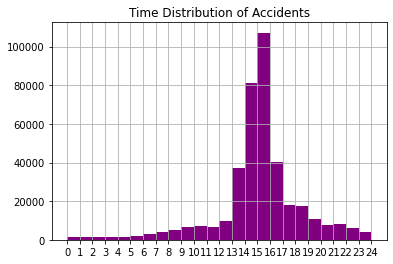

In [15]:
time_distribution = df['time'].dt.hour

xlabel = np.arange(0, 25, 1)
time_distribution.hist(bins=xlabel, color="purple")
plt.title("Time Distribution of Accidents")
plt.xticks(xlabel)
plt.show()

In [16]:
df.loc[(df.time.dt.hour >= 14)&(df.time.dt.hour <= 16)].sort_values(by="retweet", ascending=False)

,tweet_id,time,text,lang,retweet,reply,like,quoted,username,follower,following,tweet,listed,verified
243560,1436704039551520768,2021-09-11 14:51:50+00:00,Like he never left 🤩👏🏾 @Cristiano,en,21166,1081,187742,631,MarcusRashford,5068647,92,5001,3580,True
253529,1436703627775729667,2021-09-11 14:50:12+00:00,It had to be him 😍\n\n👏 @Cristiano\n\n#MUFC | ...,en,19627,1248,118551,1781,ManUtd,27208894,160,68976,23556,True
273731,1436702961061834764,2021-09-11 14:47:33+00:00,CRISTIANO RONALDO SCORES FOR MANCHESTER UNITED...,en,12709,348,73968,859,brfootball,3481431,1023,108036,8131,True
92550,1436726120402112512,2021-09-11 16:19:34+00:00,RETWEET if you’re part of Ronaldo FC. https://...,en,12408,184,30434,111,totalcristiano,78756,735,12459,238,False
130858,1436718091518492678,2021-09-11 15:47:40+00:00,A pair of Portuguese magnificos 😍🇵🇹\n\n@B_Fern...,es,12248,324,84953,442,ManUtd,27207579,160,68974,23554,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155233,1436713282535108613,2021-09-11 15:28:34+00:00,Thee expectations broker @Ronaldo\n#MUNNEW,en,0,0,0,0,beshet_sydney,338,503,4531,0,False
155235,1436713282489012226,2021-09-11 15:28:34+00:00,Cristiano Ronaldo fazendo os integrantes do Fu...,pt,0,1,0,0,FutebolGolden,1,0,12,0,False
155236,1436713282392440836,2021-09-11 15:28:34+00:00,@Cristiano je t’aime mec,fr,0,0,1,0,ZozayTheGoat,947,409,14552,1,False
155237,1436713282342203395,2021-09-11 15:28:34+00:00,"Cristiano Ronaldo é um absurdo, o cara joga, j...",pt,0,0,0,0,joaovitorsr6,195,621,768,0,False


### Word Frequency

In [17]:
len(df.loc[df['lang'] == 'en'])/len(df)*100

49.88458704242421

In [18]:
(df.groupby('lang').count()['tweet_id']/len(df)*100).sort_values(ascending=False).head()

lang
en    49.884587
es    18.962131
pt     8.456342
in     5.387564
fr     3.975649
Name: tweet_id, dtype: float64

In [19]:
def splitText(txt): #Split the text (excluding punctuation and link)
    return re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", txt).split()

words_lists = df.loc[df['lang'] == 'en','text'].str.lower().apply(lambda tweet: splitText(tweet))
words_lists.head()

1                       [manutd, cristiano, wonderful]
2                                [who, needs, ronaldo]
3    [howarddonald, manutd, cristiano, wohoo, he, s...
4    [still, rewatching, manutd, vs, newcastle, goa...
6    [thetshiamomogg1, lcfc, comments, from, the, m...
Name: text, dtype: object

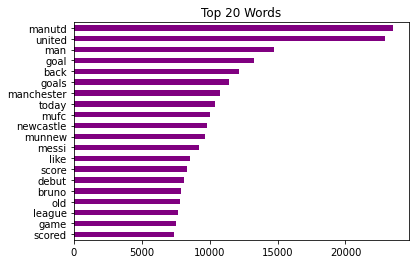

In [20]:
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(['u', 'amp', 'ronaldo', 'cristiano', '2', '1'])

words = words_lists.explode().loc[~words_lists.explode().isin(stop_words)].value_counts()
words.head(20).sort_values().plot(kind='barh',
                                  title='Top 20 Words',
                                  color='purple')
plt.show()

### Sentiment Analysis

In [21]:
df['sentiment'] = df['text'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
df.head()

,tweet_id,time,text,lang,retweet,reply,like,quoted,username,follower,following,tweet,listed,verified,sentiment
0,1436841988150726657,2021-09-11 23:59:59+00:00,prêmio veneza arroz TV GLOBINHO #GOLOUD #LBFF ...,pt,0,1,0,0,CARLSGIF,1201,1227,5619,15,False,0.00
1,1436841986879750148,2021-09-11 23:59:59+00:00,@ManUtd @Cristiano Wonderful,en,0,0,0,0,NguynTu33511542,1,25,12,0,False,1.00
2,1436841981922136065,2021-09-11 23:59:58+00:00,“Who needs Ronaldo?” https://t.co/A1J5dzWOPZ,en,0,0,4,0,afonso_santos08,147,698,5398,0,False,0.00
3,1436841981792210947,2021-09-11 23:59:58+00:00,@HowardDonald @ManUtd @Cristiano Wohoo He's ba...,en,0,0,6,0,yasmin_ali10,3204,3836,50845,3,False,0.15
4,1436841979602608130,2021-09-11 23:59:57+00:00,"still rewatching manutd vs newcastle goals, st...",en,0,0,0,0,AmirulParker,252,219,38438,1,False,0.00


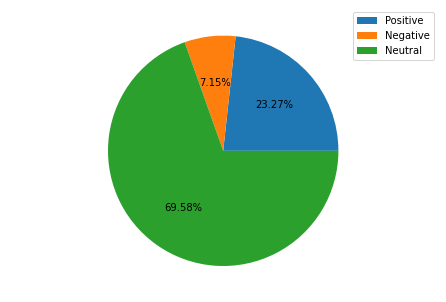

In [22]:
num_tot = df['sentiment'].count()
num_pos = df.loc[df['sentiment']>0, 'sentiment'].count()
num_neg = df.loc[df['sentiment']<-0, 'sentiment'].count()
num_neu = num_tot - num_pos - num_neg

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
sentiment = ['Positive', 'Negative', 'Neutral']
ax.pie([num_pos, num_neg, num_neu], autopct='%1.2f%%')
plt.legend(sentiment)
plt.show()